# 1)-Importing key Modules



In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
! pip install dynet

In [0]:
import pandas as pd
from collections import defaultdict
import time
import random
import dynet as dy
import numpy as np

In [4]:
! pip install version_information

In [5]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,dynet,numpy

Software versions
Python 3.6.8 64bit [GCC 8.3.0]
IPython 5.5.0
OS Linux 4.14.137+ x86_64 with Ubuntu 18.04 bionic
pandas 0.25.3
dynet 2.0.3
numpy 1.17.3
Mon Nov 11 15:49:38 2019 UTC

# 2)- Loading Data

In [6]:
df_train = pd.read_fwf('train.txt', sep='|||', names=['sentiment','sep','text','NaN'])
df_train.shape

(8544, 4)

In [7]:
df_train.head()

,sentiment,sep,text,NaN
0,3,|||,The Rock is destined to be the 21st Century 's...,NaN
1,4,|||,The gorgeously elaborate continuation of `` Th...,NaN
2,3,|||,Singer\/composer Bryan Adams contributes a sle...,NaN
3,2,|||,You 'd think by now America would have had eno...,NaN
4,3,|||,Yet the act is still charming here .,NaN


In [8]:
df_train.sentiment.value_counts()

3    2322
1    2218
2    1624
4    1288
0    1092
Name: sentiment, dtype: int64

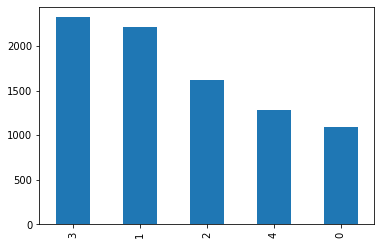

In [9]:
df_train.sentiment.value_counts().plot(kind='bar')

### loading data using traditional format
using open()

In [0]:
# Functions to read in the corpus
w2i = defaultdict(lambda: len(w2i))
t2i = defaultdict(lambda: len(t2i))
UNK = w2i["<unk>"]
def read_dataset(filename):
  with open(filename, "r") as f:
    for line in f:
      tag, words = line.lower().strip().split(" ||| ")
      yield ([w2i[x] for x in words.split(" ")], t2i[tag])

In [0]:
# Read in the data
train = list(read_dataset("train.txt"))
w2i = defaultdict(lambda: UNK, w2i)
dev = list(read_dataset("test.txt"))

In [12]:
print(len(w2i))
print(len(dev))

18648
2210


In [0]:
nwords = len(w2i)
ntags = len(t2i)

In [14]:
train[0][1]

0

In [0]:
# Start DyNet and define trainer
model = dy.ParameterCollection()
trainer = dy.AdamTrainer(model)

# 3)- Define Model

Using embedding

In [0]:
EMB_SIZE = 64
W_emb = model.add_lookup_parameters((nwords, EMB_SIZE)) # Word embeddings
W_sm = model.add_parameters((ntags, EMB_SIZE))          # Softmax weights
b_sm = model.add_parameters((ntags))                      # Softmax bias

In [0]:
# A function to calculate scores for one value
def calc_scores(words):
  dy.renew_cg()
  cbow = dy.esum([dy.lookup(W_emb, x) for x in words])
  return W_sm * cbow + b_sm

# 4)- Train the Model

In [18]:
for ITER in range(100):
  # Perform training
  random.shuffle(train)
  train_loss = 0.0
  start = time.time()
  for words, tag in train:
    my_loss = dy.pickneglogsoftmax(calc_scores(words), tag)
    train_loss += my_loss.value()
    my_loss.backward()
    trainer.update()
  print("iter %r: train loss/sent=%.4f, time=%.2fs" % (ITER, train_loss/len(train), time.time()-start))
  # Perform testing
  test_correct = 0.0
  for words, tag in dev:
    scores = calc_scores(words).npvalue()
    predict = np.argmax(scores)
    if predict == tag:
      test_correct += 1
  print("iter %r: test acc=%.4f" % (ITER, test_correct/len(dev)))

iter 0: train loss/sent=1.4614, time=0.34s
iter 0: test acc=0.4086
iter 1: train loss/sent=1.0808, time=0.32s
iter 1: test acc=0.4113
iter 2: train loss/sent=0.7768, time=0.34s
iter 2: test acc=0.4118
iter 3: train loss/sent=0.5344, time=0.33s
iter 3: test acc=0.3946
iter 4: train loss/sent=0.3703, time=0.33s
iter 4: test acc=0.3941
iter 5: train loss/sent=0.2620, time=0.34s
iter 5: test acc=0.3923
iter 6: train loss/sent=0.1794, time=0.33s
iter 6: test acc=0.3819
iter 7: train loss/sent=0.1298, time=0.34s
iter 7: test acc=0.3819
iter 8: train loss/sent=0.0953, time=0.33s
iter 8: test acc=0.3787
iter 9: train loss/sent=0.0734, time=0.33s
iter 9: test acc=0.3697
iter 10: train loss/sent=0.0571, time=0.34s
iter 10: test acc=0.3842
iter 11: train loss/sent=0.0409, time=0.34s
iter 11: test acc=0.3661
iter 12: train loss/sent=0.0349, time=0.33s
iter 12: test acc=0.3751
iter 13: train loss/sent=0.0294, time=0.34s
iter 13: test acc=0.3588
iter 14: train loss/sent=0.0254, time=0.34s
iter 14: t